In [104]:
import sys
import numpy as np
import pandas as pd
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerTuple
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import logomaker
from adjustText import adjust_text

In [105]:
sys.path.append('../../scripts/evaluate_model_runs/')
import evaluate as ae

In [106]:
plt.style.use('default')
plt.rcParams["pdf.use14corefonts"] = True
mpl.rcParams['pdf.fonttype'] = 42 
mpl.rcParams["axes.unicode_minus"] = False

In [107]:
one_letter ={'VAL':'V', 'ILE':'I', 'LEU':'L', 'GLU':'E', 'GLN':'Q', \
'ASP':'D', 'ASN':'N', 'HIS':'H', 'TRP':'W', 'PHE':'F', 'TYR':'Y',    \
'ARG':'R', 'LYS':'K', 'SER':'S', 'THR':'T', 'MET':'M', 'ALA':'A',    \
'GLY':'G', 'PRO':'P', 'CYS':'C'}
aas = one_letter.values()
pal = sns.color_palette("bright") + sns.color_palette("deep")
aa_pal = {aa:pal[i] for i, aa in enumerate(aas)}
aa_pal_logo = aa_pal.copy()
aa_to_id = {aa:i for i, aa in enumerate(aas)}
aa_to_id['nan'] = -1
aa_to_id['-']=-1
aa_numeric_pal = mpl.colors.ListedColormap([(1,1,1)] + [pal[i] for i, aa in enumerate(aas)])
aa_pal["-"] = (1,1,1)

In [108]:
clnsig_markers = {"Pathogenic/Likely_Pathogenic":"X", "Benign/Likely_Benign":"P", "":"o", np.nan:"o"}

In [109]:
ldlr_fa = "".join(pd.read_csv("../../resources/LDLR/ldlr_aa.fa").iloc[:,0].values.tolist())

In [110]:
scores_tbl = pd.read_csv("../../results/model_runs/bean_negctrl/bean_run_result.bean_count_LDLRCDS_annotated_spacer0.1_0.3/bean_element_result.MultiMixtureNormal+Acc.csv")

In [111]:
scores_tbl_merged = ae.get_dms_df(scores_tbl, variant_table_path="../../resources/LDLR/LDLR_DMS_dbNSFP_050522.xlsx")

In [112]:
domains = pd.read_csv("../../resources/LDLR/LDLR_domains.csv", comment="#")
domains[['start', 'end']] = domains["POSITION(S)"].str.split("-", expand=True)
domains[['start', 'end']] = domains[['start', 'end']].astype(int)

In [113]:
domains.loc[len(domains.index)] = ['Domain', '1-24', 'Signal Peptide', np.nan, 1, 24]

In [114]:
domains['simple_desc'] = domains.DESCRIPTION.map(lambda s: s.replace("LDL-receptor", "LDLR").replace("; calcium-binding", ""))

In [115]:
scores_tbl_merged.loc[scores_tbl_merged.coding == "coding", "ref_aa"] = scores_tbl_merged.loc[scores_tbl_merged.coding == "coding", "ref"]
scores_tbl_merged.loc[scores_tbl_merged.coding == "coding", "domain"] = "N/A"
scores_tbl_merged.loc[scores_tbl_merged.coding == "coding", "domain"] = scores_tbl_merged.loc[scores_tbl_merged.coding == "coding", "pos"].map(lambda s: int(s.split("A")[-1])).map(lambda i: domains.loc[(domains.start <= i) & (domains.end >= i), 'simple_desc'].iloc[0] if any((domains.start <= i) & (domains.end >= i)) else "N/A")

In [116]:
domains = pd.read_csv("../../resources/LDLR/LDLR_domains.csv", comment="#")
domains[['start', 'end']] = domains["POSITION(S)"].str.split("-", expand=True)
domains[['start', 'end']] = domains[['start', 'end']].astype(int)

In [117]:
tbl = scores_tbl_merged

In [118]:
domains['sequence'] = domains.apply(lambda row: ldlr_fa[row.start-1:row.end], axis=1)

In [119]:
tbl.loc[tbl.coding=='coding', 'int_pos'] = tbl.loc[tbl.coding=='coding', 'pos'].map(lambda s: int(s.split("A")[-1]))

In [120]:
coding_vars = tbl.loc[tbl.coding == 'coding']
domain_info = coding_vars.int_pos.map(lambda i: domains.loc[(domains.start <= i) & (domains.end >= i), ['DESCRIPTION', 'start', 'end']].values[0].tolist() if any((domains.start <= i) & (domains.end >= i)) else ["", -1, -1])
coding_vars.loc[:,['domain', 'domain_start', 'domain_end']] = pd.DataFrame(domain_info.tolist(), columns=['domain', 'domain_start', 'domain_end']).values

<ipython-input-120-cd45b8fdf75a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coding_vars.loc[:,['domain', 'domain_start', 'domain_end']] = pd.DataFrame(domain_info.tolist(), columns=['domain', 'domain_start', 'domain_end']).values
<ipython-input-120-cd45b8fdf75a>:3: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  coding_vars.loc[:,['domain', 'domain_start', 'domain_end']] = pd.DataFrame(domain_info.tolist(), columns=['domain', 'domain_start', 'domain_end']).values


In [121]:
coding_vars['domain_rel_pos'] = coding_vars.int_pos - coding_vars.domain_start

<ipython-input-121-a34ced56c03c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coding_vars['domain_rel_pos'] = coding_vars.int_pos - coding_vars.domain_start


In [122]:
coding_vars.clinvar_clnsig.value_counts()

Likely_pathogenic                               84
Pathogenic/Likely_pathogenic                    35
Conflicting_interpretations_of_pathogenicity    27
Uncertain_significance                          16
Pathogenic                                      12
Likely_benign                                   10
not_provided                                     6
Benign                                           3
Benign/Likely_benign                             2
Name: clinvar_clnsig, dtype: int64

In [123]:
def convert_if_possible(s):
    try: 
        x= int(s.split("; calcium-binding")[0][-1])
    except:
        x=0
    return x

In [124]:
coding_vars['domain_family'] = coding_vars.domain.map(lambda s: re.split(r" \d", s)[0])
coding_vars['domain_family_idx'] = coding_vars.domain.map(lambda s: convert_if_possible(s))
#coding_vars.domain_family_idx = coding_vars.domain_family_idx.map(lambda s: int(s) if s != "" else 0

<ipython-input-124-a22cb8685f73>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coding_vars['domain_family'] = coding_vars.domain.map(lambda s: re.split(r" \d", s)[0])
<ipython-input-124-a22cb8685f73>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coding_vars['domain_family_idx'] = coding_vars.domain.map(lambda s: convert_if_possible(s))


In [125]:
ldlr_a = coding_vars.loc[coding_vars.domain_family == "LDL-receptor class A", :]

In [126]:
base_by_pos = ldlr_a.pivot_table(values='ref', index='domain_rel_pos', columns='domain_family_idx', aggfunc='first')

In [127]:
def print_fa(base_by_pos, ref = "GSEGKTCGPSSFSCPGTHVCVPERWLCDGDKDCADGADESIAAGCLYNST"):
    print(">ref")
    print(ref)
    for i in range(len(base_by_pos.columns)):
        print(f">{i}")
        print("".join(base_by_pos.iloc[:,i].map(lambda x: "-" if not isinstance(x, str) else x).tolist()))

In [128]:
def print_fa_from_ref(domain_df, ref = "GSEGKTCGPSSFSCPGTHVCVPERWLCDGDKDCADGADESIAAGCLYNST"):
    print(">ref")
    print(ref)
    for i in range(len(domain_df)):
        print(f">{i}")
        print(domain_df.loc[i, 'sequence'])

In [129]:
print_fa(base_by_pos)

>ref
GSEGKTCGPSSFSCPGTHVCVPERWLCDGDKDCADGADESIAAGCLYNST
>0
DRCERNEFQCQD-KCISYKWVCD-SAECQD-SDESQETCLS
>1
VTCKS-DFSC--RVN-CIPQFWRCD-QVDCDN-SDEQ-C--
>2
KTCSQDEF-CHD-KCIS-QFVCDSD-DCLD-SDE-SC-V--
>3
LTCG--SFQCNSSTCI-QLW-CDND-DCED-SDEW-Q-CRG
>4
S-C--FEFHCLS-ECIHSSW-CDG--DCKDKSDEENCAV--
>5
-TC-PDEFQCSDGNCIH-S-QCD-EYDCKDMSDEV-CVN--
>6
TLCEG-NKFKCHS-ECITLDKVCNMARDC-DWSDE-IKEC-


In [130]:
def parse_alignment(alignment_result, hit_line_start = 11):
    alignments = []
    gap_dict = {}
    alignment_result = alignment_result.split("\n\n\n")[-1]
    for i, line in enumerate(alignment_result.split("\n")):
        if line[0] == ' ': break
        if line[:3] == "ref":
            i=-1
            alignment = line[3:].strip().split("\t")[0]
        else: 
            i = int(line[0])
            alignment = line[1:].strip().split("\t")[0]
        ref_idx = 0
        gap_list = []
        for aligned_idx, aligned_char in enumerate([*alignment]):
            if aligned_char == '-': gap_list.append(ref_idx)
            else: ref_idx += 1
        gap_dict[i] = gap_list
    hit_pos = np.where(np.array([*line[hit_line_start:]]) != " ")[0]
    return gap_dict, hit_pos

In [131]:
# https://www.ebi.ac.uk/Tools/msa/clustalo/
alignment_result = '''CLUSTAL O(1.2.4) multiple sequence alignment


ref        GSEGKTC-GPSSFSCPG-THVCVPERWLCDGDKDCADGADESIAAGCLYNST	50
3          ----LTC-GPASFQCNS--STCIPQLWACDNDPDCEDGSDEWPQR-CRG---	41
1          ----VTC-KSGDFSCGGRVNRCIPQFWRCDGQVDCDNGSDEQG---CPP-	40
6          ----TLCEGPNKFKCHS--GECITLDKVCNMARDCRDWSDEPIKE-C----	41
0          ----DRC-ERNEFQCQD--GKCISYKWVCDGSAECQDGSDESQET-CLS---	41
2          ----KTC-SQDEFRCHD--GKCISRQFVCDSDRDCLDGSDEAS---CPV---	39
4          ----SPC-SAFEFHCLS--GECIHSSWRCDGGPDCKDKSDEEN---CAV---	39
5          ----ATC-RPDEFQCSD--GNCIHGSRQCDREYDCKDMSDEVG---CVN---	39
                 *    .* * .    *:     *:   :* : :**     *     '''


In [132]:
ca_positions=[26,29,33,39,40]

In [133]:
c_positions = [6,14,21,28,34,46]

In [134]:
gap_dict, hit_pos_a = parse_alignment(alignment_result)

In [135]:
ldlr_a['domain_rel_pos_aligned'] = ldlr_a['domain_rel_pos']
for i, gaps in gap_dict.items():
    if i == -1: domain_family_idx = -1
    else: domain_family_idx = base_by_pos.columns[i]
    print(f"{domain_family_idx}:{gaps}")
    for gap in gaps:
        ldlr_a.loc[(ldlr_a.domain_family_idx == domain_family_idx)&(ldlr_a.domain_rel_pos >= gap), "domain_rel_pos_aligned"] += 1

-1:[7, 16]
4:[0, 0, 0, 0, 3, 12, 12, 38, 41, 41, 41]
2:[0, 0, 0, 0, 3, 38, 38, 38, 41]
7:[0, 0, 0, 0, 13, 13, 39, 40, 40, 40, 40]
1:[0, 0, 0, 0, 3, 12, 12, 38, 41, 41, 41]
3:[0, 0, 0, 0, 3, 12, 12, 36, 36, 36, 39, 39, 39]
5:[0, 0, 0, 0, 3, 12, 12, 36, 36, 36, 39, 39, 39]
6:[0, 0, 0, 0, 3, 12, 12, 36, 36, 36, 39, 39, 39]


<ipython-input-135-6cde26e8de61>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldlr_a['domain_rel_pos_aligned'] = ldlr_a['domain_rel_pos']


In [136]:
base_by_pos_a = ldlr_a.pivot_table(values='ref', index='domain_rel_pos_aligned', columns='domain_family_idx', aggfunc='first')
base_by_pos_a.style.apply(lambda row: ['background: yellow' if (row.name in hit_pos_a) else '' for i in row], axis=1)

domain_family_idx,1,2,3,4,5,6,7
domain_rel_pos_aligned,,,,,,,
4,D,V,K,L,S,nan,T
5,R,T,T,T,nan,T,L
6,C,C,C,C,C,C,C
7,nan,nan,nan,nan,nan,nan,E
8,E,K,S,G,nan,nan,G
9,R,S,Q,nan,nan,P,nan
10,N,nan,D,nan,F,D,N
11,E,D,E,S,E,E,K
12,F,F,F,F,F,F,F


In [137]:
ref_seq = pd.Series(list("GSEGKTC-GPSSFSCPG-THVCVPERWLCDGDKDCADGADESIAAGCLYNST"))
base_by_pos_a = pd.concat([ref_seq, base_by_pos_a], axis=1)

In [138]:
def normalize_columns(df, cols):
    for c in cols:
        df[f"{c}_norm"] = df[c]/df[c].abs().max()
    return df

In [139]:
ldlr_a_ms = ldlr_a.loc[ldlr_a.ref != ldlr_a.alt]

In [140]:
clnsig_colormap = {
    "Pathogenic":np.array((1,0,0)),
    "Likely_pathogenic":np.array((1,0,0)),
    "Pathogenic/Likely_pathogenic":np.array((1,0,0)), 
    "Benign/Likely_Benign":np.array((0,0,1)), 
    "Benign/Likely_benign":np.array((0,0,1)), 
    "Benign":np.array((0,0,1)),
    "Likely_benign":np.array((0,0,1)),
    "Conflicting_interpretations_of_pathogenicity":np.array((1,0,1)),
    "Uncertain_significance":np.array((0,0,0)),
    "not_provided":np.array((1,1,1)),
    np.nan:np.array((1,1,1)),
}

In [141]:
clnsig_colormap_uncertain = {
    "Pathogenic":np.array((1,1,1)),
    "Likely_pathogenic":np.array((1,1,1)),
    "Pathogenic/Likely_pathogenic":np.array((1,1,1)),
    "Benign/Likely_Benign":np.array((1,1,1)),
    "Benign/Likely_benign":np.array((1,1,1)),
    "Benign":np.array((1,1,1)),
    "Likely_benign":np.array((1,1,1)),
    "Conflicting_interpretations_of_pathogenicity":np.array((1,0,1)),
    "Uncertain_significance":np.array((0,0,0)),
    "not_provided":np.array((1,1,1)),
    np.nan:np.array((1,1,1)),
}

In [142]:
coding_vars.clinvar_clnsig.value_counts()

Likely_pathogenic                               84
Pathogenic/Likely_pathogenic                    35
Conflicting_interpretations_of_pathogenicity    27
Uncertain_significance                          16
Pathogenic                                      12
Likely_benign                                   10
not_provided                                     6
Benign                                           3
Benign/Likely_benign                             2
Name: clinvar_clnsig, dtype: int64

In [143]:
ldlr_a.to_csv("20230505_ldlr_a_0.1_0.3.csv")

In [144]:
ldlr_a.loc[ldlr_a.clinvar_annot_2.isnull(), "clinvar_annot_2"]= ""

In [145]:
aa_pal[np.nan] = 'white'
aa_pal['-'] = 'black'

### Plot with PFAM

In [146]:
ldlr_a_logo_tbl = pd.read_table("../../resources/LDLR/pf00057_skylign_logo.txt", header=3, index_col=0).reset_index(drop=True)
ldlr_a_logo_tbl["aligned_pos"] = pd.read_excel("../../resources/LDLR/Ldl_recept_a.hmm.xlsx", header=3).rename(columns={"re-align":'domain_rel_pos_aligned'}).domain_rel_pos_aligned
ldlr_a_logo_tbl = ldlr_a_logo_tbl.set_index("aligned_pos").reindex(list(range(4,50))).fillna(0)

In [153]:
max(ldlr_a.sig_size.abs())

7.2748184

<ipython-input-209-f5d5fbe18425>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldlr_a['sig_size'] =ldlr_a["mu_z_adj"].abs()


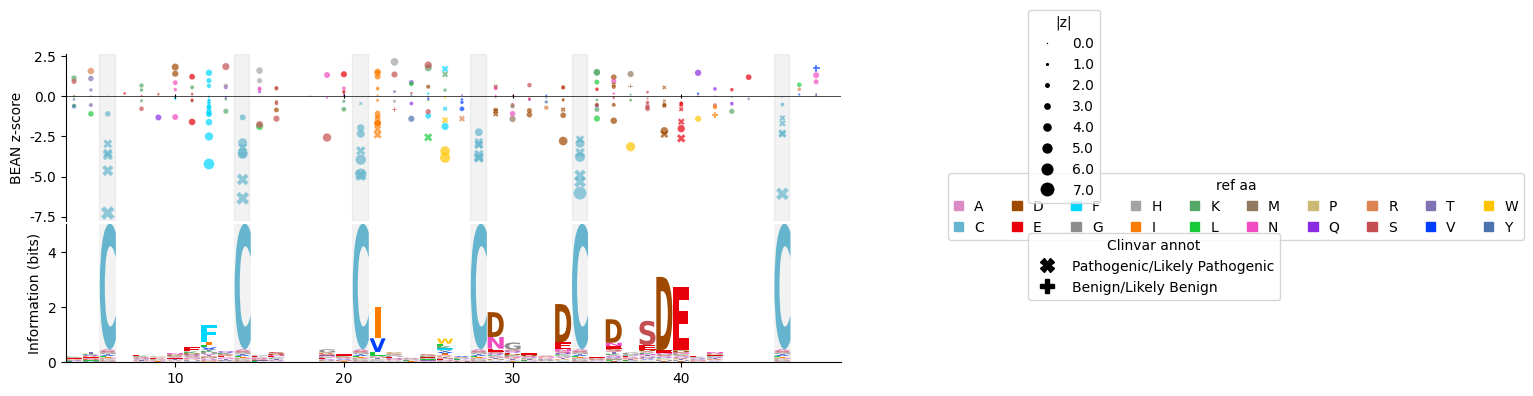

In [209]:
fig, ax = plt.subplots(2, 1, figsize=(10, 4), sharex=True, gridspec_kw={'height_ratios': [1.2, 1]})
fdr_thres=0.01
def plot_label(df, ax, x_col, y_col):
    for i in range(df.shape[0]):
        ax.text(x=df[x_col].tolist()[i], y=df[y_col].tolist()[i]-0.1, s = df.variant.tolist()[i], fontdict=dict(size=5))

ldlr_a['sig_size'] =ldlr_a["mu_z_adj"].abs()
for i in range(len(ldlr_a.domain_family_idx.unique())):
    plt_tbl = ldlr_a.loc[ldlr_a.domain_family_idx == i+1, :].copy()
    plt_tbl_nonsyn = plt_tbl.loc[plt_tbl.ref != plt_tbl.alt,:].copy()
    if i == 0:
        for c_pos in c_positions:
            ax[0].axvspan(c_pos-0.5, c_pos +0.4, color='grey', alpha=0.1)
    sns.scatterplot(data=plt_tbl_nonsyn, x='domain_rel_pos_aligned', y='mu_z_adj', style = "clinvar_annot_2", markers = clnsig_markers, hue='ref', palette=aa_pal, ax=ax[0], alpha=0.7, size='sig_size', sizes=(1,100), size_norm=(0,7))    
    ax[0].get_legend().remove()
ax[0].set_ylabel("BEAN z-score")
ax[0].set_xlabel(None)
ax[0].axhline(0, color='black', linewidth=0.5)
ax[0].spines['top'].set_position('zero')
ax[0].tick_params(axis='x', bottom=False, top=True, direction='inout')

aa_handles = [mpatches.Patch(color=col, label=aa) for aa, col in sorted(aa_pal_logo.items())]
legend = fig.legend(handles=aa_handles, bbox_to_anchor=(1, 0.5), loc="center left", title="ref aa", handlelength=0.7, ncols=10)

clin_handles2 = [
    Line2D([], [], color="None", marker='X', markerfacecolor="black", markersize=10),
    Line2D([], [], color="None", marker='P', markerfacecolor="black", markersize=10),
]
legend2 = fig.legend(handles=clin_handles2, labels=["Pathogenic/Likely Pathogenic", "Benign/Likely Benign"], bbox_to_anchor=(1.08, 0.35), loc="center left", title="Clinvar annot")

n=8
sig_handles = [
    (Line2D([], [], color="None", marker='o', markersize=s, markerfacecolor="black", markeredgecolor="None"),
    ) for s in np.linspace(1,10,n) # s = markersize**2, see https://stackoverflow.com/questions/14827650/pyplot-scatter-plot-marker-size
]
legend3 = fig.legend(handles=sig_handles, labels=np.linspace(0, 7, n).tolist(), bbox_to_anchor=(1.08, 0.75), loc="center left", title="|z|", handler_map={tuple: HandlerTuple(ndivide=None, pad=5)}, scatterpoints = 3)

ldlr_a_logo = logomaker.Logo(ldlr_a_logo_tbl.iloc[:,:-4], ax = ax[1], color_scheme = aa_pal_logo)
for c in c_positions:
    ldlr_a_logo.highlight_position(p=c, color='grey', alpha=0.1)
ax[1].set_ylabel("Information (bits)")
sns.despine(fig, right=True, top=True)
sns.despine(ax=ax[0], bottom=True)
plt.subplots_adjust(hspace=0.02)
fig.savefig("5e_ldlr_a_with_logo_v4.pdf")

<ipython-input-162-64f0f6333ac0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldlr_a['sig_size'] = ldlr_a["mu_z_adj"].abs()


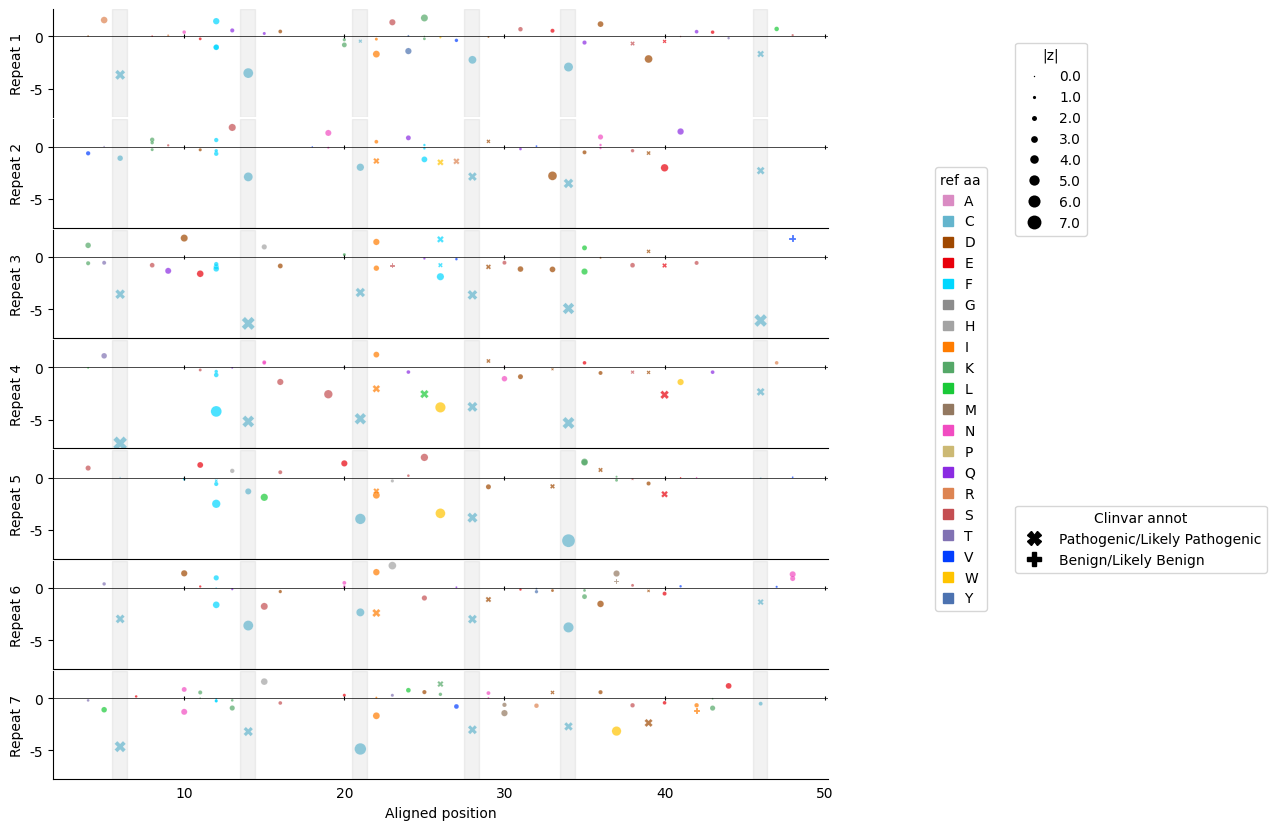

In [162]:
fig, ax = plt.subplots(7, 1, figsize=(10, 10), sharex=True, sharey=True)
fdr_thres=0.01
def plot_label(df, ax, x_col, y_col):
    for i in range(df.shape[0]):
        ax.text(x=df[x_col].tolist()[i], y=df[y_col].tolist()[i]-0.1, s = df.variant.tolist()[i], fontdict=dict(size=5))

ldlr_a['sig_size'] = ldlr_a["mu_z_adj"].abs()
for i in range(len(ldlr_a.domain_family_idx.unique())):
    plt_tbl = ldlr_a.loc[ldlr_a.domain_family_idx == i+1, :].copy()
    plt_tbl_nonsyn = plt_tbl.loc[plt_tbl.ref != plt_tbl.alt,:].copy()
    for c_pos in c_positions:
        ax[i].axvspan(c_pos-0.5, c_pos +0.4, color='grey', alpha=0.1)
    sns.scatterplot(data=plt_tbl_nonsyn, x='domain_rel_pos_aligned', y='mu_z_adj', style = "clinvar_annot_2", markers = clnsig_markers, hue='ref', palette=aa_pal, ax=ax[i], alpha=0.7, size='sig_size', sizes=(1,100), size_norm=(0,7))    
    ax[i].get_legend().remove()
    ax[i].set_ylabel(f"Repeat {i+1}")
    ax[i].set_xlabel(None)
    ax[i].axhline(0, color='black', linewidth=0.5)
    ax[i].spines['top'].set_position('zero')
    ax[i].tick_params(axis='x', bottom=False, top=True, direction='inout')

ax[-1].set_xlabel("Aligned position")
aa_handles = [mpatches.Patch(color=col, label=aa) for aa, col in sorted(aa_pal_logo.items())]
legend = fig.legend(handles=aa_handles, bbox_to_anchor=(1, 0.5), loc="center left", title="ref aa", handlelength=0.7)

clin_handles2 = [
    Line2D([], [], color="None", marker='X', markerfacecolor="black", markersize=10),
    Line2D([], [], color="None", marker='P', markerfacecolor="black", markersize=10),
]
legend2 = fig.legend(handles=clin_handles2, labels=["Pathogenic/Likely Pathogenic", "Benign/Likely Benign"], bbox_to_anchor=(1.08, 0.35), loc="center left", title="Clinvar annot")

n=8
sig_handles = [
    (Line2D([], [], color="None", marker='o', markersize=s, markerfacecolor="black", markeredgecolor="None"),
    ) for s in np.linspace(1,10,n) # s = markersize**2, see https://stackoverflow.com/questions/14827650/pyplot-scatter-plot-marker-size
]
legend3 = fig.legend(handles=sig_handles, labels=np.linspace(0, 7, n).tolist(), bbox_to_anchor=(1.08, 0.75), loc="center left", title="|z|", handler_map={tuple: HandlerTuple(ndivide=None, pad=5)}, scatterpoints = 3)

for c in c_positions:
    ldlr_a_logo.highlight_position(p=c, color='grey', alpha=0.1)
sns.despine(fig, right=True, top=True)
sns.despine(ax=ax[0], bottom=True)
plt.subplots_adjust(hspace=0.02)

fig.savefig("5e_ldlr_a_each_repeat.pdf")

<ipython-input-164-c411d119b9e1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldlr_a['sig_size'] = ldlr_a["mu_z_adj"].abs()


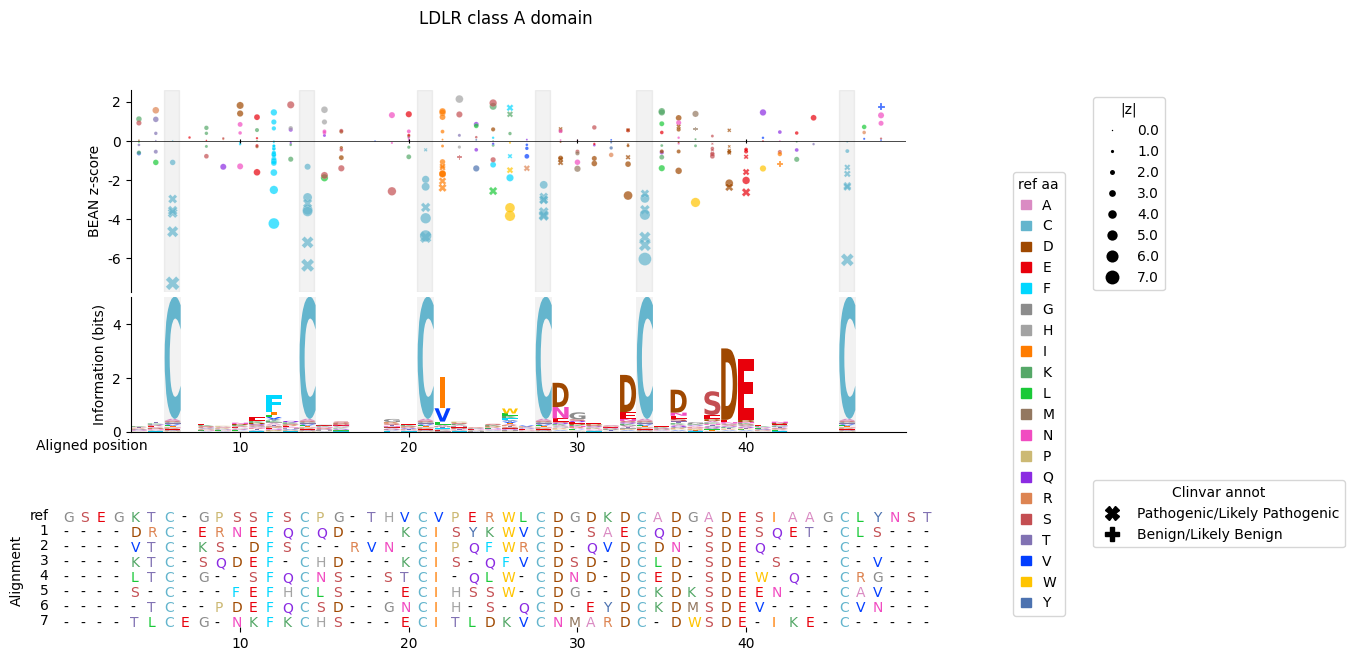

In [164]:
fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [1.5, 1, 2]})

ldlr_a['sig_size'] = ldlr_a["mu_z_adj"].abs()
for i in range(len(ldlr_a.domain_family_idx.unique())):
    plt_tbl = ldlr_a.loc[ldlr_a.domain_family_idx == i+1, :].copy()
    plt_tbl_nonsyn = plt_tbl.loc[plt_tbl.ref != plt_tbl.alt,:].copy()
    if i == 0:
        for c_pos in c_positions:
            ax[0].axvspan(c_pos-0.5, c_pos +0.4, color='grey', alpha=0.1)
    sns.scatterplot(data=plt_tbl_nonsyn, x='domain_rel_pos_aligned', y='mu_z_adj', style = "clinvar_annot_2", markers = clnsig_markers, hue='ref', palette=aa_pal, ax=ax[0], alpha=0.7, size='sig_size', sizes=(1,100), size_norm=(0,7))    
    ax[0].get_legend().remove()
ax[0].set_ylabel("BEAN z-score")
ax[0].set_xlabel(None)
ax[0].axhline(0, color='black', linewidth=0.5)
ax[0].spines['top'].set_position('zero')
ax[0].tick_params(axis='x', bottom=False, top=True, direction='inout')

aa_handles = [mpatches.Patch(color=col, label=aa) for aa, col in sorted(aa_pal_logo.items())]
legend = fig.legend(handles=aa_handles, bbox_to_anchor=(1, 0.5), loc="center left", title="ref aa", handlelength=0.7)

clin_handles2 = [
    Line2D([], [], color="None", marker='X', markerfacecolor="black", markersize=10),
    Line2D([], [], color="None", marker='P', markerfacecolor="black", markersize=10),
]
legend2 = fig.legend(handles=clin_handles2, labels=["Pathogenic/Likely Pathogenic", "Benign/Likely Benign"], bbox_to_anchor=(1.08, 0.35), loc="center left", title="Clinvar annot")

n=8
sig_handles = [
    (Line2D([], [], color="None", marker='o', markersize=s, markerfacecolor="black", markeredgecolor="None"),
    ) for s in np.linspace(1,10,n) # s = markersize**2, see https://stackoverflow.com/questions/14827650/pyplot-scatter-plot-marker-size
]
legend3 = fig.legend(handles=sig_handles, labels=np.linspace(0, 7, n).tolist(), bbox_to_anchor=(1.08, 0.75), loc="center left", title="|z|", handler_map={tuple: HandlerTuple(ndivide=None, pad=5)}, scatterpoints = 3)

ldlr_a_logo = logomaker.Logo(ldlr_a_logo_tbl.iloc[:,:-4], ax = ax[1], color_scheme = aa_pal_logo)
for c in c_positions:
    if c in ldlr_a_logo_tbl.index: ldlr_a_logo.highlight_position(p=int(c), color='grey', alpha=0.1)
ax[1].set_ylabel("Information (bits)")
ax[1].xaxis.set_tick_params(which='both', labelbottom=True)
ax[1].set_xlabel("Aligned position")
ax[1].xaxis.set_label_coords(-0.05, -0.05)

### Alignment
pb = base_by_pos_a.T
pb['rep'] = pb.index
pb = pd.melt(pb, id_vars='rep', var_name='domain_rel_pos_aligned')

texts = [
    ax[2].text(df['domain_rel_pos_aligned']-0.5, 
               -df['rep']/pb.rep.max()+1, 
               df.value if df.value is not np.nan else "-", 
               color=aa_pal[df.value if df.value is not np.nan else "-"]
              ) for i, df in pb.iterrows()]
ax[2].spines[['right', 'top', 'left', 'bottom']].set_visible(False)
ax[2].set_box_aspect(ldlr_a.domain_family_idx.max()/ldlr_a.domain_rel_pos_aligned.max())
ax[2].set_yticks(-(pb['rep'].unique()-0.5)/pb.rep.max()+1)
ax[2].set_ylabel("Alignment")
ax[2].tick_params(axis='y', which='both', length=0)
ax[2].set_yticklabels((["ref"] + list(range(1, 8))))
ax[2].spines["left"].set_position(("axes", -0.1))#set_yticklabels(["ref"] + list(range(1, 7)))
plt.suptitle("LDLR class A domain")

sns.despine(fig, right=True, top=True)
sns.despine(ax=ax[0], bottom=True)
sns.despine(ax=ax[2], bottom=True, left=True)
plt.subplots_adjust(hspace=0.02)
fig.savefig("5e_ldlr_a_with_logo_alignment_v4.pdf")

## LDLR class B

In [165]:
coding_vars['domain_rel_pos'] = coding_vars.int_pos - coding_vars.domain_start

<ipython-input-165-a34ced56c03c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coding_vars['domain_rel_pos'] = coding_vars.int_pos - coding_vars.domain_start


In [166]:
ldlr_b = coding_vars.loc[coding_vars.domain_family == "LDL-receptor class B", :]

In [167]:
ldlr_b_domains = domains.loc[domains.DESCRIPTION.map(lambda s: "class B" in s)].reset_index()
print_fa_from_ref(ldlr_b_domains, ref="gklYWtDwsldasisvadlnGshrktlfqedlqnPrgiAvDp")

>ref
gklYWtDwsldasisvadlnGshrktlfqedlqnPrgiAvDp
>0
SIAYLFFTNRHEVRKMTLDRSEYTSLIPNLRNVVALDTEVAS
>1
NRIYWSDLSQRMICSTQLDRAHGVSSYDTVISRDIQAPDGLAVDWIH
>2
SNIYWTDSVLGTVSVADTKGVKRKTLFRENGSKPRAIVVDPVH
>3
GFMYWTDWGTPAKIKKGGLNGVDIYSLVTENIQWPNGITLDLLS
>4
GRLYWVDSKLHSISSIDVNGGNRKTILEDEKRLAHPFSLAVFE
>5
DKVFWTDIINEAIFSANRLTGSDVNLLAENLLSPEDMVLFHNL


In [168]:
"gklYWtDwsldasisvadlnGshrktlfqedlqnPrgiAvDp".upper()

'GKLYWTDWSLDASISVADLNGSHRKTLFQEDLQNPRGIAVDP'

In [169]:
base_by_pos = ldlr_b.pivot_table(values='ref', index='domain_rel_pos', columns='domain_family_idx', aggfunc='first')#.reindex(np.arange(0,53))
alignment_result = '''CLUSTAL O(1.2.4) multiple sequence alignment


ref                       --gklYWtDws-ldasisvadlnGsh----rktlfqedl--qnPrgiAvDp----	42	41
0                         SIAYLFFTNRHE----VRKMTLDRSE----YTSLIP-NL----RNVVALDTEVAS	42	37
1                         --NRIYWSDLS--QRMICSTQLDRAHGVSSYDTVISRDI--QAPDGLAVDWIH--	47	44
2                         --SNIYWTDSV--LGTVSVADTKGVK----RKTLFRENG--SKPRAIVVDPVH--	43	40
3                         --GFMYWTDWG-TPAKIKKGGLNGVD----IYSLVTENI--QWPNGITLDLLS--	44	41
4                         --GRLYWVDSK--LHSISSIDVNGGN----RKTILEDEKRLAHPFSLAVFE----	43	42
5                         --DKVFWTDII--NEAIFSANRLTGSD---VNLLAE-NL--LSPEDMVLFHNL--	43	40
                              ::: :       :                             : : 
                                                           '''
gap_dict, hit_pos_b = parse_alignment(alignment_result, 26)

In [170]:
def get_gap_pos(is_gap_seq):
    ref_idx = 0
    gap_list = []
    for pos, is_gap in enumerate(is_gap_seq):
        if is_gap: gap_list.append(ref_idx)
        else: ref_idx += 1
    return gap_list

ldlr_b['domain_rel_pos_aligned'] = ldlr_b['domain_rel_pos']

for i, gaps in gap_dict.items():
    if i == -1: continue
    else: domain_family_idx = i+1
    print(f"{domain_family_idx}:{gaps}")
    ref_gaps = get_gap_pos(base_by_pos[domain_family_idx].isnull())
    ref_gap_pos = np.array(ref_gaps)
    print(ref_gaps)
    #if ref_gaps == -1: ref_gaps = np.array([])
    for gap in gaps:
#         if gap in ref_gaps: 
#             ref_gaps.remove(gap)
#             continue
        #gap_offset = sum(ref_gap_pos < gap)
        ldlr_b.loc[(ldlr_b.domain_family == "LDL-receptor class B")&(ldlr_b.domain_family_idx == domain_family_idx)&(ldlr_b.domain_rel_pos >= gap), "domain_rel_pos_aligned"] += 1

1:[12, 12, 12, 12, 22, 22, 22, 22, 28, 30, 30, 30, 30]
[2, 8, 17, 24, 36, 37, 37, 37, 37, 37]
2:[0, 0, 9, 9, 35, 35, 47, 47]
[20, 21, 34, 34, 35]
3:[0, 0, 9, 9, 22, 22, 22, 22, 31, 31, 43, 43]
[10, 14, 17, 23, 26, 30, 37, 37, 37, 37]
4:[0, 0, 9, 23, 23, 23, 23, 32, 32, 44, 44]
[0, 9, 9, 13, 13, 24, 28, 29, 36, 36, 36]
5:[0, 0, 9, 9, 22, 22, 22, 22, 43, 43, 43, 43]
[0, 0, 17, 17, 18, 27, 27, 28, 31, 34, 34, 34, 34]
6:[0, 0, 9, 9, 23, 23, 23, 29, 31, 31, 43, 43]
[3, 8, 8, 8, 11, 12, 26, 36, 36, 36, 36]


<ipython-input-170-5d5c80d12807>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldlr_b['domain_rel_pos_aligned'] = ldlr_b['domain_rel_pos']


In [171]:
base_by_pos_b = ldlr_b.pivot_table(values='ref', index='domain_rel_pos_aligned', columns='domain_family_idx', aggfunc='last').reindex(np.arange(0, 53))
base_by_pos_b.style.apply(lambda row: ['background: yellow' if (row.name in hit_pos_b) else '' for i in row], axis=1)

domain_family_idx,1,2,3,4,5,6
domain_rel_pos_aligned,,,,,,
0,S,nan,nan,nan,nan,nan
1,I,nan,nan,nan,nan,nan
2,nan,N,S,nan,nan,D
3,Y,R,N,F,nan,K
4,L,I,I,M,L,V
5,F,Y,Y,Y,Y,nan
6,F,W,W,W,W,W
7,T,S,T,T,V,T
8,N,D,D,D,D,D


In [172]:
ref_seq = pd.Series(list("--gklYWtDws-ldasisvadlnGsh----rktlfqedl--qnPrgiAvDp----".upper()))
base_by_pos_b = pd.concat([ref_seq, base_by_pos_b], axis=1)

In [173]:
ldlr_b.to_csv("20230629_ldlr_b_0.1_0.3.csv")

In [174]:
ldlr_b.domain_family_idx.unique()

array([2, 3, 4, 5, 6, 1])

In [175]:
ldlr_b_logo_tbl = pd.read_table("../../resources/LDLR/pf00058_skylign_logo.txt", header=3, index_col=0).reset_index(drop=True)
ldlr_b_logo_tbl["aligned_pos"] = pd.read_excel("../../resources/LDLR/Ldl_recept_b.hmm.xlsx", header=2).rename(columns={"re-align":'domain_rel_pos_aligned'}).domain_rel_pos_aligned
ldlr_b_logo_tbl = ldlr_b_logo_tbl.set_index("aligned_pos").reindex(list(range(max(ldlr_b_logo_tbl["aligned_pos"])))).fillna(0)

In [176]:
ldlr_b.loc[ldlr_b.clinvar_annot_2.isnull(),"clinvar_annot_2"] = ""

In [177]:
ldlr_b.mu_z_adj.min()

-4.2649927

<ipython-input-181-5e0ae3e95502>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldlr_b['sig_size'] = ldlr_b.mu_z_adj.abs()


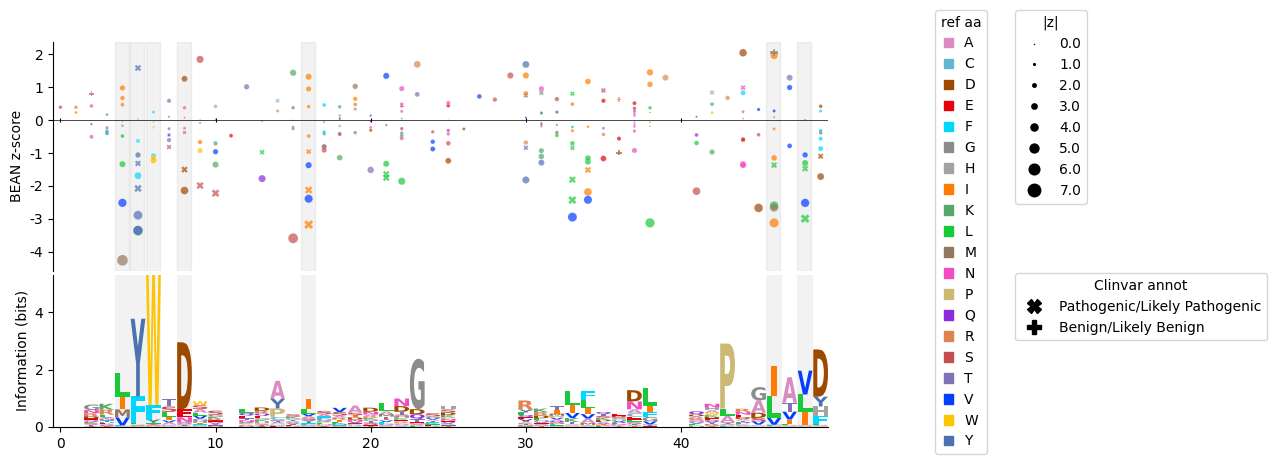

In [181]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True, gridspec_kw={'height_ratios': [1.5, 1]})
fdr_thres=0.01
def plot_label(df, ax, x_col, y_col):
    for i in range(df.shape[0]):
        ax.text(x=df[x_col].tolist()[i], y=df[y_col].tolist()[i]-0.1, s = df.variant.tolist()[i], fontdict=dict(size=5))

ldlr_b['sig_size'] = ldlr_b.mu_z_adj.abs()
max_sig = 7
for i in range(len(ldlr_b.domain_family_idx.unique())):
    plt_tbl = ldlr_b.loc[ldlr_b.domain_family_idx == i+1, :].copy()
    plt_tbl_nonsyn = plt_tbl.loc[plt_tbl.ref != plt_tbl.alt,:].copy()
    if i == 0:
        for c_pos in hit_pos_b:
            ax[0].axvspan(c_pos-0.5, c_pos +0.4, color='grey', alpha=0.1)
    sns.scatterplot(data=plt_tbl_nonsyn, x='domain_rel_pos_aligned', y='mu_z_adj', style = "clinvar_annot_2", markers = clnsig_markers, hue='ref', palette=aa_pal, ax=ax[0], alpha=0.7, size='sig_size', sizes=(1,100), size_norm=(0,max_sig))    
    ax[0].get_legend().remove()
ax[0].set_ylabel("BEAN z-score")
ax[0].set_xlabel(None)
ax[0].axhline(0, color='black', linewidth=0.5)
ax[0].spines['top'].set_position('zero')
ax[0].tick_params(axis='x', bottom=False, top=True, direction='inout')

aa_handles = [mpatches.Patch(color=col, label=aa) for aa, col in sorted(aa_pal_logo.items())]
legend = fig.legend(handles=aa_handles, bbox_to_anchor=(1, 0.5), loc="center left", title="ref aa", handlelength=0.7)

clin_handles2 = [
    Line2D([], [], color="None", marker='X', markerfacecolor="black", markersize=10),
    Line2D([], [], color="None", marker='P', markerfacecolor="black", markersize=10),
]
legend2 = fig.legend(handles=clin_handles2, labels=["Pathogenic/Likely Pathogenic", "Benign/Likely Benign"], bbox_to_anchor=(1.08, 0.35), loc="center left", title="Clinvar annot")

n=8
sig_handles = [
    (Line2D([], [], color="None", marker='o', markersize=s, markerfacecolor="black", markeredgecolor="None"),
    ) for s in np.linspace(1,10,n) # s = markersize**2, see https://stackoverflow.com/questions/14827650/pyplot-scatter-plot-marker-size
]
legend3 = fig.legend(handles=sig_handles, labels=np.linspace(0, max_sig, n).tolist(), bbox_to_anchor=(1.08, 0.75), loc="center left", title="|z|", handler_map={tuple: HandlerTuple(ndivide=None, pad=5)}, scatterpoints = 3)

ldlr_b_logo = logomaker.Logo(ldlr_b_logo_tbl.iloc[:,:-4], ax = ax[1], color_scheme = aa_pal_logo)
for c in hit_pos_b:
    ldlr_b_logo.highlight_position(p=int(c), color='grey', alpha=0.1)
ax[1].set_ylabel("Information (bits)")
sns.despine(fig, right=True, top=True)
sns.despine(ax=ax[0], bottom=True)
plt.subplots_adjust(hspace=0.02)
fig.savefig("5e_ldlr_b_with_logo_v4.pdf")

In [182]:
ldlr_b['aastr'] = ldlr_b.ref + ldlr_b.int_pos.astype(str) + ldlr_b.alt

<ipython-input-182-64c411f1e24d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldlr_b['aastr'] = ldlr_b.ref + ldlr_b.int_pos.astype(str) + ldlr_b.alt


In [183]:
plot_vars = ["M531T", "S584P", "Y489H", "I566T", "Y576H", "L426P", "Y532H", "M652T", "S584P", "M652V", "I566V", "M531V"]
pos_show = sorted(ldlr_b.loc[ldlr_b.aastr.isin(plot_vars), "domain_rel_pos_aligned"].unique())

In [186]:
ldlr_b_show = ldlr_b.loc[ldlr_b.domain_rel_pos_aligned.isin(pos_show)]

In [187]:
clnsig_markers["VUS"] = "v"
clnsig_markers["Conflicting"] = "D"

In [188]:
ldlr_b["clinvar_annot_4"] = ldlr_b.clinvar_annot_2
ldlr_b.loc[ldlr_b.clinvar_clnsig == "Conflicting_interpretations_of_pathogenicity", "clinvar_annot_4"] = "Conflicting"
ldlr_b.loc[ldlr_b.clinvar_clnsig == "Uncertain_significance", "clinvar_annot_4"] = "VUS"
ldlr_b.loc[ldlr_b.clinvar_annot_4.isnull(), "clinvar_annot_4"] = ""

<ipython-input-188-40238207716e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldlr_b["clinvar_annot_4"] = ldlr_b.clinvar_annot_2


In [211]:
#variants = ["M531T", "S584P", "Y489H", "I566T", "Y576H", "L426P", "Y532H", "M652T", "S584P", "M652V", "I566V", "M531V", "Y532C"]
variants = ["Y442C", "V481A", "Y468A", "Y489H", "M531T", "Y532C", "L568P", "Y576H", "V618A", "M652V", "I566V", "M531V", "L426P", "M531T", "I566T", "S584P",]

<ipython-input-213-90a8c3781a70>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldlr_b['sig_size'] = ldlr_b['sig_size'] = ldlr_b.mu_z_adj.abs()
<ipython-input-213-90a8c3781a70>:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=plt_tbl_nonsyn, x='domain_rel_pos_aligned', y='mu_z_adj', style = "clinvar_annot_4", markers = clnsig_markers, hue='ref', palette=aa_pal, ax=ax[0, j], alpha=0.7, size='sig_size', sizes=(9,100), size_norm=(0,3))
<ipython-input-213-90a8c3781a70>:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=plt_tbl_nonsyn, x='domain_rel_pos_aligned', y='mu_z_adj', style = "clinvar_annot_4", markers = clnsig_markers, hue='ref', pal

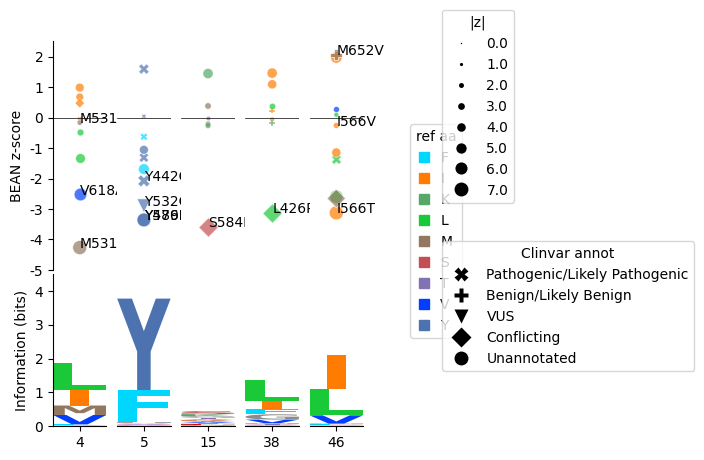

In [213]:
fig, ax = plt.subplots(2, len(pos_show), figsize=(4, 5), gridspec_kw={'height_ratios': [1.5, 1]})
fdr_thres=0.01
def plot_label(df, ax, x_col, y_col):
    for i in range(df.shape[0]):
        ax.text(x=df[x_col].tolist()[i], y=df[y_col].tolist()[i]-0.1, s = df.variant.tolist()[i], fontdict=dict(size=5))

ldlr_b['sig_size'] = ldlr_b['sig_size'] = ldlr_b.mu_z_adj.abs()

texts_dict = {i:[] for i in range(len(pos_show))}
for j, r in enumerate(pos_show):
    for i in range(len(ldlr_b.domain_family_idx.unique())):
        plt_tbl = ldlr_b.loc[ldlr_b.domain_family_idx == i+1, :].copy()
        plt_tbl_nonsyn = plt_tbl.loc[(plt_tbl.ref != plt_tbl.alt) & (plt_tbl.domain_rel_pos_aligned==r),:].copy()
        sns.scatterplot(data=plt_tbl_nonsyn, x='domain_rel_pos_aligned', y='mu_z_adj', style = "clinvar_annot_4", markers = clnsig_markers, hue='ref', palette=aa_pal, ax=ax[0, j], alpha=0.7, size='sig_size', sizes=(9,100), size_norm=(0,3))    
        texts_dict[j].extend([ax[0, j].text(df['domain_rel_pos_aligned'], df['mu_z_adj'], df['aastr']) for _, df in plt_tbl_nonsyn.loc[plt_tbl_nonsyn.aastr.isin(variants)].iterrows()] )
    ax[0, j].get_legend().remove()
    ax[0, j].set_ylabel("")
    ax[0, j].set_xlabel(None)
    ax[0, j].axhline(0, color='black', linewidth=0.5)
    ax[0, j].spines['top'].set_position('zero')
    ax[0, j].tick_params(axis='x', bottom=False, top=True, direction='inout')
    ax[0, j].set_ylim((-5, 2.5))
    ax[0, j].set_xticks([], [])
    sns.despine(ax=ax[0, j], bottom=True)
    if j != 0: 
        sns.despine(ax=ax[0, j], left=True, bottom=True)
        ax[0, j].set_yticks([], [])
ax[0, 0].set_ylabel("BEAN z-score")

aa_handles = [mpatches.Patch(color=col, label=aa) for aa, col in sorted(aa_pal_logo.items()) if aa in ldlr_b_show.ref.unique()]
legend = fig.legend(handles=aa_handles, bbox_to_anchor=(1, 0.5), loc="center left", title="ref aa", handlelength=0.7)

clin_handles2 = [
    Line2D([], [], color="None", marker='X', markerfacecolor="black", markersize=10, markeredgecolor="None"),
    Line2D([], [], color="None", marker='P', markerfacecolor="black", markersize=10, markeredgecolor="None"),
    Line2D([], [], color="None", marker='v', markerfacecolor="black", markersize=10, markeredgecolor="None"),
    Line2D([], [], color="None", marker='D', markerfacecolor="black", markersize=10, markeredgecolor="None"),
    Line2D([], [], color="None", marker='o', markerfacecolor="black", markersize=10, markeredgecolor="None"),
]
legend2 = fig.legend(handles=clin_handles2, labels=["Pathogenic/Likely Pathogenic", "Benign/Likely Benign", "VUS", "Conflicting", "Unannotated"], bbox_to_anchor=(1.08, 0.35), loc="center left", title="Clinvar annot")

n=8
sig_handles = [
    (Line2D([], [], color="None", marker='o', markersize=s, markerfacecolor="black", markeredgecolor="None"),
    ) for s in np.linspace(1,10,n) # s = markersize**2, see https://stackoverflow.com/questions/14827650/pyplot-scatter-plot-marker-size
]
legend3 = fig.legend(handles=sig_handles, labels=np.linspace(0, max_sig, n).tolist(), bbox_to_anchor=(1.08, 0.75), loc="center left", title="|z|", handler_map={tuple: HandlerTuple(ndivide=None, pad=5)}, scatterpoints = 3)

for j, pos in enumerate(pos_show):
    ldlr_b_logo = logomaker.Logo(ldlr_b_logo_tbl.iloc[[pos],:-4], ax = ax[1, j], color_scheme = aa_pal_logo)
    ax[1, j].set_ylim((0, 4.5))
    ax[1, j].set_xticks([pos], [pos])
    sns.despine(ax=ax[1, j], right=True, top=True)
    if j != 0: 
        sns.despine(ax=ax[1, j], left=True)
        ax[1, j].set_yticks([], [])
ax[1, 0].set_ylabel("Information (bits)")

plt.subplots_adjust(hspace=0.02)

fig.savefig("5e_ldlr_b_with_logo_label_v5.pdf", bbox_inches="tight")

<ipython-input-190-c845f0ed578c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldlr_b['sig_size'] = ldlr_b.mu_z_adj.abs()


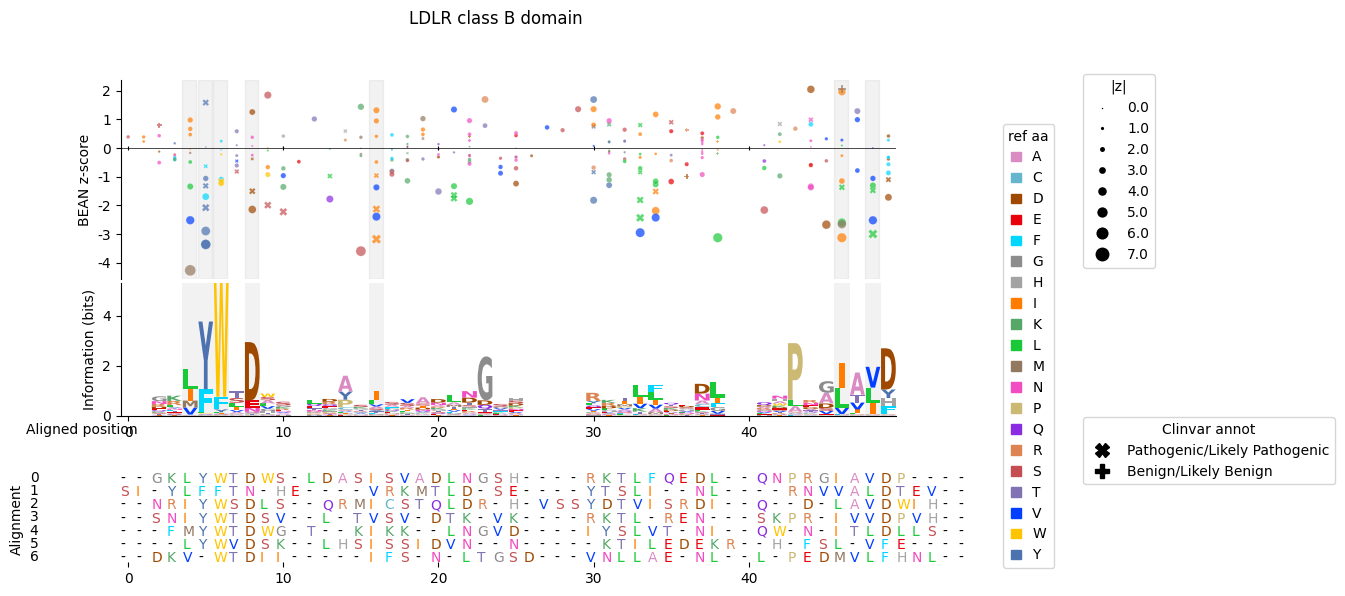

In [190]:
fig, ax = plt.subplots(3, 1, figsize=(10, 7), sharex=True, gridspec_kw={'height_ratios': [1.5, 1, 1.5]})

ldlr_b['sig_size'] = ldlr_b.mu_z_adj.abs()
for i in range(len(ldlr_b.domain_family_idx.unique())):
    plt_tbl = ldlr_b.loc[ldlr_b.domain_family_idx == i+1, :].copy()
    plt_tbl['pathogenic_size'] = (plt_tbl.clinvar_annot_2 == "Pathogenic/Likely_Pathogenic").map({True:20, False:10})
    plt_tbl_nonsyn = plt_tbl.loc[plt_tbl.ref != plt_tbl.alt,:].copy()
    if i == 0:
        for c_pos in hit_pos_b:
            ax[0].axvspan(c_pos-0.5, c_pos +0.4, color='grey', alpha=0.1)
    sns.scatterplot(data=plt_tbl_nonsyn, x='domain_rel_pos_aligned', y='mu_z_adj', ax=ax[0], 
                    style = "clinvar_annot_2", markers = clnsig_markers, 
                    hue='ref', palette=aa_pal, alpha=0.7, 
                    size='sig_size', sizes=(1,100), size_norm=(0,7)
                   )    
    ax[0].get_legend().remove()
ax[0].set_ylabel("BEAN z-score")
ax[0].set_xlabel(None)
ax[0].axhline(0, color='black', linewidth=0.5)
ax[0].spines['top'].set_position('zero')
ax[0].tick_params(axis='x', bottom=False, top=True, direction='inout')

aa_handles = [mpatches.Patch(color=col, label=aa) for aa, col in sorted(aa_pal_logo.items())]
legend = fig.legend(handles=aa_handles, bbox_to_anchor=(1, 0.5), loc="center left", title="ref aa", handlelength=0.7)

clin_handles2 = [
    Line2D([], [], color="None", marker='X', markerfacecolor="black", markersize=10),
    Line2D([], [], color="None", marker='P', markerfacecolor="black", markersize=10),
]
legend2 = fig.legend(handles=clin_handles2, labels=["Pathogenic/Likely Pathogenic", "Benign/Likely Benign"], bbox_to_anchor=(1.08, 0.35), loc="center left", title="Clinvar annot")


n=8
sig_handles = [
    (Line2D([], [], color="None", marker='o', markersize=s, markerfacecolor="black", markeredgecolor="None"),
    ) for s in np.linspace(1,10,n) # s = markersize**2, see https://stackoverflow.com/questions/14827650/pyplot-scatter-plot-marker-size
]
legend3 = fig.legend(handles=sig_handles, labels=np.linspace(0, max_sig, n).tolist(), bbox_to_anchor=(1.08, 0.75), loc="center left", title="|z|", handler_map={tuple: HandlerTuple(ndivide=None, pad=5)}, scatterpoints = 3)

ldlr_b_logo = logomaker.Logo(ldlr_b_logo_tbl.iloc[:,:-4], ax = ax[1], color_scheme = aa_pal_logo)
for c in hit_pos_b:
    if c in ldlr_b_logo_tbl.index: ldlr_b_logo.highlight_position(p=int(c), color='grey', alpha=0.1)
ax[1].set_ylabel("Information (bits)")
ax[1].xaxis.set_tick_params(which='both', labelbottom=True)
ax[1].set_xlabel("Aligned position")
ax[1].xaxis.set_label_coords(-0.05, -0.05)

### Alignment
pb = base_by_pos_b.T
pb['rep'] = pb.index
pb = pd.melt(pb, id_vars='rep', var_name='domain_rel_pos_aligned')

texts = [
    ax[2].text(df['domain_rel_pos_aligned']-0.5, 
               -df['rep']/pb.rep.max()+1, 
               df.value if df.value is not np.nan else "-", 
               color=aa_pal[df.value if df.value is not np.nan else "-"]
              ) for i, df in pb.iterrows()]
ax[2].spines[['right', 'top', 'left', 'bottom']].set_visible(False)
ax[2].set_box_aspect(ldlr_b.domain_family_idx.max()/ldlr_b.domain_rel_pos_aligned.max())
ax[2].set_yticks(-(pb['rep'].unique()-0.5)/pb.rep.max()+1)
ax[2].set_ylabel("Alignment")
ax[2].tick_params(axis='y', which='both', length=0)
ax[2].set_yticklabels(base_by_pos_b.columns)
ax[2].spines["left"].set_position(("axes", -0.1))
plt.suptitle("LDLR class B domain")

sns.despine(fig, right=True, top=True)
sns.despine(ax=ax[0], bottom=True)
sns.despine(ax=ax[2], bottom=True, left=True)
plt.subplots_adjust(hspace=0.02)
fig.savefig("5e_ldlr_b_with_logo_alignment_v4.pdf")

# EGF-like

In [191]:
egf = coding_vars.loc[coding_vars.domain_family == "EGF-like", :]

In [192]:
egf.loc[egf.clinvar_annot_2.isnull(), "clinvar_annot_2"] = ""

In [193]:
egf_domains = domains.loc[domains.DESCRIPTION.map(lambda s: "EGF" in s)].reset_index()
egf_domains

,index,ID,POSITION(S),DESCRIPTION,source,start,end,sequence
0,7,Domain,314-353,EGF-like 1,PROSITE-ProRule Annotation,314,353,GTNECLDNNGGCSHVCNDLKIGYECLCPDGFQLVAQRRCE
1,8,Domain,354-393,EGF-like 2; calcium-binding,PROSITE-ProRule Annotation,354,393,DIDECQDPDTCSQLCVNLEGGYKCQCEEGFQLDPHTKACK
2,15,Domain,663-712,EGF-like 3,PROSITE-ProRule Annotation,663,712,GVNWCERTTLSNGGCQYLCLPAPQINPHSPKFTCACPDGMLLARDM...


In [194]:
egf_logo_tbl = pd.read_table("../../resources/LDLR/pf00008_skylign_logo.txt", header=3, index_col=0).reset_index(drop=True)

In [195]:
egf_logo_tbl["consensus"] = egf_logo_tbl.columns[egf_logo_tbl.iloc[:,:-4].values.argmax(axis=1)]

In [196]:
print_fa_from_ref(egf_domains, ref="".join(egf_logo_tbl["consensus"].tolist()))

>ref
CSPNPCSNGGTCVDTGRGGYTCECPEGYTGKR
>0
GTNECLDNNGGCSHVCNDLKIGYECLCPDGFQLVAQRRCE
>1
DIDECQDPDTCSQLCVNLEGGYKCQCEEGFQLDPHTKACK
>2
GVNWCERTTLSNGGCQYLCLPAPQINPHSPKFTCACPDGMLLARDMRSCL


In [197]:
#http://pfam-legacy.xfam.org/family/pf00008#tabview=tab3
seed = pd.read_table("../../resources/LDLR/PF00008_seed.txt", header=None, delim_whitespace=True)

In [198]:
for i, row in seed.iterrows():
    print(f">{row[0]}")
    print(row[1])

>BM86_RHIMP/209-245
CKTKEAGFVCKHGCRSTGKAYECTCPSGSTVAEDGIT
>AGRIN_CHICK/1351-1381
CDSHPCLHGGTCEDDGREFTCRCPAGKGGAV
>A4V346_DROME/260-287
CVLEPNCIHGTCNKPWTCICNEGWGGLY
>PROS_BOVIN/121-153
CNPLPCNEDGFMTCKDGQATFTCICKSGWQGEK
>CRB_DROME/1209-1239
CKPNPCHSNGECTDLWHTFACHCPRPFFGHT
>CRB_DROME/1483-1513
CRKNPCLHNAECRNTWNDYTCKCPNGYKGKN
>SLIT_DROME/1052-1084
CSPEFNPCANGAKCMDHFTHYSCDCQAGFHGTN
>O01768_CAEEL/4584-4614
CDDYCTNNSKCTITNGTHFECDCKPGFKGLR
>CRB_DROME/982-1017
CDQNPCLNGGACLPYLINEVTHLYNCTCENGFQGDK
>MFGM_MOUSE/68-106
CSPNPCYNDAKCLVTLDTQRGDIFTEYICQCPVGYSGIH
>M9NE67_DROME/871-903
CASNRCKNEAKCTPSSNFLDFSCTCKLGYTGRY
>NOTC1_XENLA/62-97
CTIKNQCMNFGTCEPVLQGNAIDFICHCPVGFTDKV
>URT2_DESRO/87-119
CSELRCFNGGTCWQAASFSDFVCQCPKGYTGKQ
>M9NE67_DROME/100-134
CNSMRCQNGGTCQVTFRNGRPGISCKCPLGFDESL
>CRB_DROME/547-577
CNATNGKCLNGGTCSMNGTHCYCAVGYSGDR
>NOTC1_XENLA/260-290
CPSNNCRNGGTCVDGVNTYNCQCPPDWTGQY
>CRB_DROME/390-421
CASQPCQNNGSCIDRINGFSCDCSGTGYTGAF
>PROC_BOVIN/98-127
CDLPCCGRGKCIDGLGGFRCDCAEGWEGRF
>LYAM1_HUMAN/160-19

In [199]:
# https://www.ebi.ac.uk/Tools/msa/clustalo/
alignment_result = '''CLUSTAL O(1.2.4) multiple sequence alignment


ref                         -----CSPNPCSNG----G----TCVDTG-----RGGYTCECPEGYT----GKR--	29
1                           ------GTNECLDNN---GGCSHVCNDL----KI--GYECLCPDGFQLVAQRRCE-	35
2                           DIDECQDPDTCS------QLCV-----N-----LEGGYKCQCEEGFQLDPHTKACK	34
3                           ------GVNWCERTTLSNGGCQYLCLPAPQINPHSPKFTCACPDGMLLARDMRSCL	44
                                                                   * *         '''

In [200]:
gap_dict, hit_pos_egf = parse_alignment(alignment_result, hit_line_start=28)

In [201]:
egf['domain_rel_pos_aligned'] = egf['domain_rel_pos']
egf_logo_tbl['domain_rel_pos'] = egf_logo_tbl['domain_rel_pos_aligned'] = egf_logo_tbl.index.tolist()
for i, gaps in gap_dict.items():
    if i == -1: 
        for gap in gaps:
        	egf_logo_tbl.loc[egf_logo_tbl.domain_rel_pos >= gap, "domain_rel_pos_aligned"] += 1
        continue
    print(f"{i}:{gaps}")
    for gap in gaps:
        egf.loc[(egf.domain_family_idx == i)&(egf.domain_rel_pos >= gap), "domain_rel_pos_aligned"] += 1

1:[0, 0, 0, 0, 0, 0, 9, 9, 9, 19, 19, 19, 19, 21, 21, 40]
2:[12, 12, 12, 12, 12, 12, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17]
3:[0, 0, 0, 0, 0, 0]


<ipython-input-201-ae3a18cd007f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  egf['domain_rel_pos_aligned'] = egf['domain_rel_pos']


In [202]:
egf_logo_tbl = egf_logo_tbl.set_index("domain_rel_pos_aligned").reindex(list(range(max(egf_logo_tbl.domain_rel_pos_aligned)))).fillna(0)
egf_logo_tbl.loc[egf_logo_tbl.consensus == 0,'consensus'] = np.nan

In [203]:
base_by_pos_egf = egf.pivot_table(values='ref', index='domain_rel_pos_aligned', columns='domain_family_idx', aggfunc='first')
base_by_pos_egf = pd.concat([egf_logo_tbl[["consensus"]], base_by_pos_egf], axis=1)
base_by_pos_egf.style.apply(lambda row: ['background: yellow' if (row.name in hit_pos_egf) else '' for i in row], axis=1)

,consensus,1,2,3
domain_rel_pos_aligned,,,,
0,nan,nan,D,nan
1,nan,nan,I,nan
2,nan,nan,D,nan
3,nan,nan,E,nan
4,nan,nan,C,nan
5,C,nan,Q,nan
6,S,nan,D,G
7,P,T,nan,V
8,N,N,D,N


In [204]:
egf.to_csv("20230629_egf_0.1_0.3.csv")

In [205]:
clnsig_markers

{'Pathogenic/Likely_Pathogenic': 'X',
 'Benign/Likely_Benign': 'P',
 '': 'o',
 nan: 'o',
 'VUS': 'v',
 'Conflicting': 'D'}

<ipython-input-206-2bcae453eb93>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  egf['sig_size'] = egf.mu_z_adj.abs()


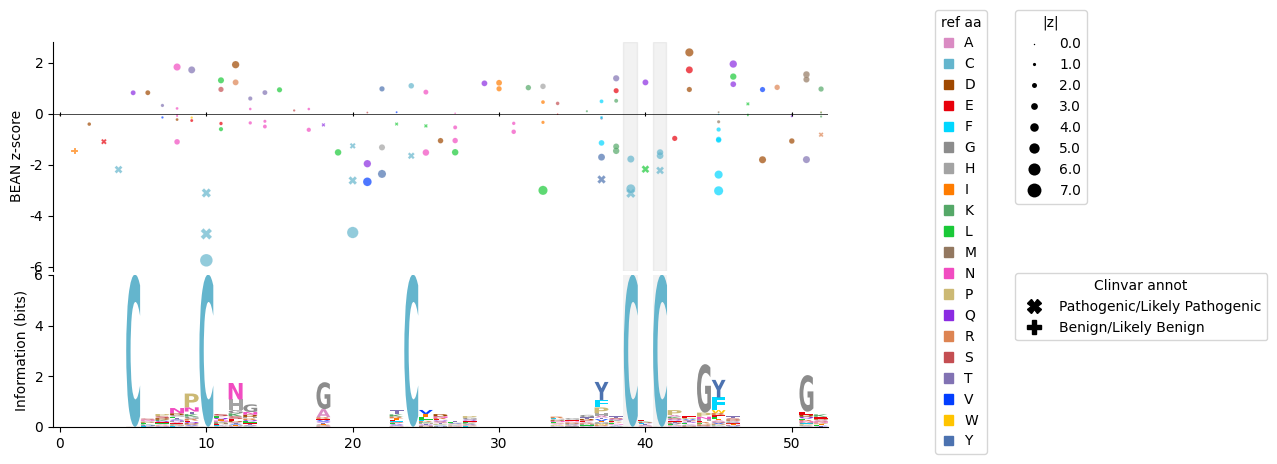

In [206]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True, gridspec_kw={'height_ratios': [1.5, 1]})
fdr_thres=0.01
def plot_label(df, ax, x_col, y_col):
    for i in range(df.shape[0]):
        ax.text(x=df[x_col].tolist()[i], y=df[y_col].tolist()[i]-0.1, s = df.variant.tolist()[i], fontdict=dict(size=5))

egf['sig_size'] = egf.mu_z_adj.abs()
for i in range(len(egf.domain_family_idx.unique())):
    plt_tbl = egf.loc[egf.domain_family_idx == i+1, :].copy()
    plt_tbl_nonsyn = plt_tbl.loc[plt_tbl.ref != plt_tbl.alt,:].copy()
    if i == 0:
        for c_pos in hit_pos_egf:
            ax[0].axvspan(c_pos-0.5, c_pos +0.4, color='grey', alpha=0.1)
    sns.scatterplot(data=plt_tbl_nonsyn, x='domain_rel_pos_aligned', y='mu_z_adj', style = "clinvar_annot_2", markers = clnsig_markers, hue='ref', palette=aa_pal, ax=ax[0], alpha=0.7, size='sig_size', sizes=(1,100), size_norm=(0,7))    
    ax[0].get_legend().remove()
ax[0].set_ylabel("BEAN z-score")
ax[0].set_xlabel(None)
ax[0].axhline(0, color='black', linewidth=0.5)
ax[0].spines['top'].set_position('zero')
ax[0].tick_params(axis='x', bottom=False, top=True, direction='inout')

aa_handles = [mpatches.Patch(color=col, label=aa) for aa, col in sorted(aa_pal_logo.items())]
legend = fig.legend(handles=aa_handles, bbox_to_anchor=(1, 0.5), loc="center left", title="ref aa", handlelength=0.7)

clin_handles2 = [
    Line2D([], [], color="None", marker='X', markerfacecolor="black", markersize=10),
    Line2D([], [], color="None", marker='P', markerfacecolor="black", markersize=10),
]
legend2 = fig.legend(handles=clin_handles2, labels=["Pathogenic/Likely Pathogenic", "Benign/Likely Benign"], bbox_to_anchor=(1.08, 0.35), loc="center left", title="Clinvar annot")


n=8
sig_handles = [
    (Line2D([], [], color="None", marker='o', markersize=s, markerfacecolor="black", markeredgecolor="None"),
    ) for s in np.linspace(1,10,n) # s = markersize**2, see https://stackoverflow.com/questions/14827650/pyplot-scatter-plot-marker-size
]
legend3 = fig.legend(handles=sig_handles, labels=np.linspace(0, max_sig, n).tolist(), bbox_to_anchor=(1.08, 0.75), loc="center left", title="|z|", handler_map={tuple: HandlerTuple(ndivide=None, pad=5)}, scatterpoints = 3)

egf_logo = logomaker.Logo(egf_logo_tbl.iloc[:,:-6], ax = ax[1], color_scheme = aa_pal_logo)
for c in hit_pos_egf:
    egf_logo.highlight_position(p=int(c), color='grey', alpha=0.1)
ax[1].set_ylabel("Information (bits)")
sns.despine(fig, right=True, top=True)
sns.despine(ax=ax[0], bottom=True)
plt.subplots_adjust(hspace=0.02)
fig.savefig("5e_egf_with_logo_v4.pdf")

<ipython-input-207-962ee7a4f746>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  egf['sig_size'] = egf.mu_z_adj.abs()


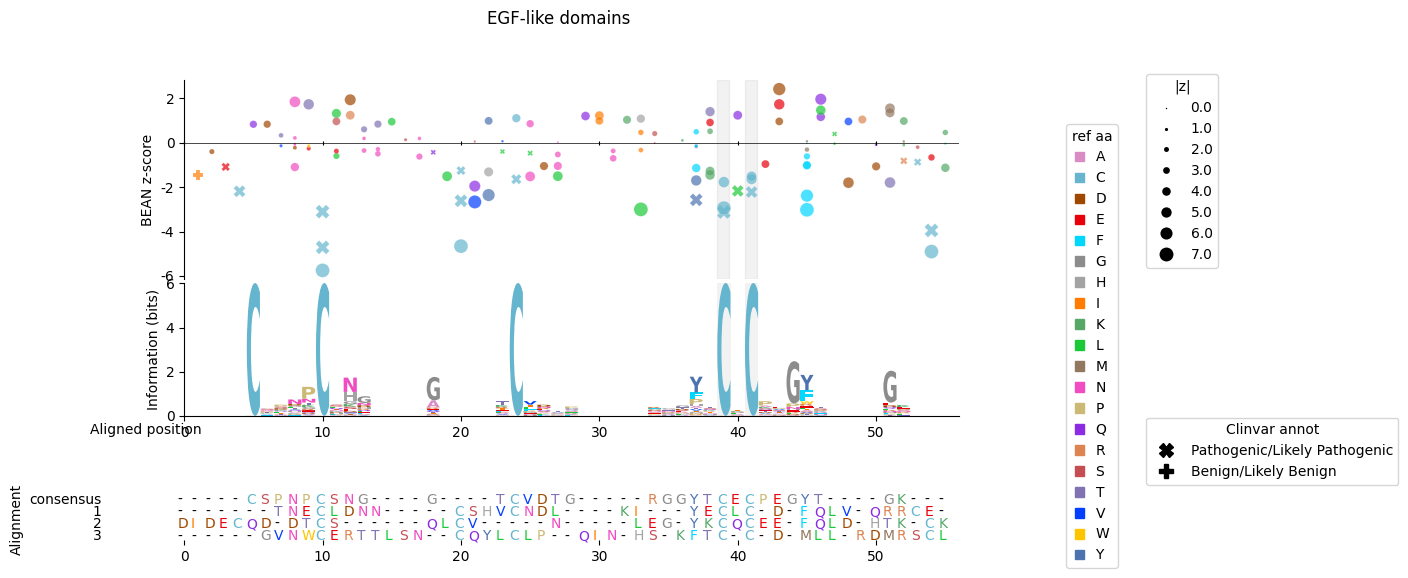

In [207]:
fig, ax = plt.subplots(3, 1, figsize=(10, 7), sharex=True, gridspec_kw={'height_ratios': [1.5, 1, 1.5]})

egf['sig_size'] = egf.mu_z_adj.abs()
for i in range(len(egf.domain_family_idx.unique())):
    plt_tbl = egf.loc[egf.domain_family_idx == i+1, :].copy()
    plt_tbl['pathogenic_size'] = (plt_tbl.clinvar_annot_2 == "Pathogenic/Likely_Pathogenic").map({True:20, False:10})
    plt_tbl_nonsyn = plt_tbl.loc[plt_tbl.ref != plt_tbl.alt,:].copy()
    if i == 0:
        for c_pos in hit_pos_egf:
            ax[0].axvspan(c_pos-0.5, c_pos +0.4, color='grey', alpha=0.1)
    sns.scatterplot(data=plt_tbl_nonsyn, x='domain_rel_pos_aligned', y='mu_z_adj', ax=ax[0], 
                    style = "clinvar_annot_2", markers = clnsig_markers, 
                    hue='ref', palette=aa_pal, alpha=0.7, 
                    size='sig_size', sizes=(1,100), size_norm=(0,3)
                   )    
    ax[0].get_legend().remove()
ax[0].set_ylabel("BEAN z-score")
ax[0].set_xlabel(None)
ax[0].axhline(0, color='black', linewidth=0.5)
ax[0].spines['top'].set_position('zero')
ax[0].tick_params(axis='x', bottom=False, top=True, direction='inout')

aa_handles = [mpatches.Patch(color=col, label=aa) for aa, col in sorted(aa_pal_logo.items())]
legend = fig.legend(handles=aa_handles, bbox_to_anchor=(1, 0.5), loc="center left", title="ref aa", handlelength=0.7)

clin_handles2 = [
    Line2D([], [], color="None", marker='X', markerfacecolor="black", markersize=10),
    Line2D([], [], color="None", marker='P', markerfacecolor="black", markersize=10),
]
legend2 = fig.legend(handles=clin_handles2, labels=["Pathogenic/Likely Pathogenic", "Benign/Likely Benign"], bbox_to_anchor=(1.08, 0.35), loc="center left", title="Clinvar annot")

n=8
sig_handles = [
    (Line2D([], [], color="None", marker='o', markersize=s, markerfacecolor="black", markeredgecolor="None"),
    ) for s in np.linspace(1,10,n) # s = markersize**2, see https://stackoverflow.com/questions/14827650/pyplot-scatter-plot-marker-size
]
legend3 = fig.legend(handles=sig_handles, labels=np.linspace(0, max_sig, n).tolist(), bbox_to_anchor=(1.08, 0.75), loc="center left", title="|z|", handler_map={tuple: HandlerTuple(ndivide=None, pad=5)}, scatterpoints = 3)

egf_logo = logomaker.Logo(egf_logo_tbl.iloc[:,:-6], ax = ax[1], color_scheme = aa_pal_logo)
for c in hit_pos_egf:
    if c in egf_logo_tbl.index: egf_logo.highlight_position(p=int(c), color='grey', alpha=0.1)
ax[1].set_ylabel("Information (bits)")
ax[1].xaxis.set_tick_params(which='both', labelbottom=True)
ax[1].set_xlabel("Aligned position")
ax[1].xaxis.set_label_coords(-0.05, -0.05)
ax[1].set_xlim((0, 56))
### Alignment
pb = base_by_pos_egf.T
pb['rep'] = list(range(len(pb.index)))
pb = pd.melt(pb, id_vars='rep', var_name='domain_rel_pos_aligned')

texts = [
    ax[2].text(df['domain_rel_pos_aligned']-0.5, 
               -df['rep']/pb.rep.max()+1, 
               df.value if df.value is not np.nan else "-", 
               color=aa_pal[df.value if df.value is not np.nan else "-"]
              ) for i, df in pb.iterrows()]
ax[2].spines[['right', 'top', 'left', 'bottom']].set_visible(False)
ax[2].set_box_aspect(egf.domain_family_idx.max()/egf.domain_rel_pos_aligned.max())
ax[2].set_yticks(-(pb['rep'].unique()-0.5)/pb.rep.max()+1)
ax[2].set_ylabel("Alignment")
ax[2].tick_params(axis='y', which='both', length=0)
ax[2].set_yticklabels(base_by_pos_egf.columns)
ax[2].spines["left"].set_position(("axes", -0.1))
plt.suptitle("EGF-like domains")

sns.despine(fig, right=True, top=True)
sns.despine(ax=ax[0], bottom=True)
sns.despine(ax=ax[2], bottom=True, left=True)
plt.subplots_adjust(hspace=0.02)
fig.savefig("5e_egf_with_logo_alignment_v4.pdf")